Instruction
For the analysis, you should:
1. Use pre-processing techniques (such as filtering) if necessary.
2. Detect R-peaks of each ECG record
3. Extract features from the shape of the heart cycles: e,g., amplitude and duration of QRS
complex, duration of the ST segment, T-wave duration (see ecg features).
4. Divide your dataset into the training set and test set (70-30% split).
5. Standardize your data: i.e., use the mean and standard deviation of the training data to
standardize the training data and the test data.
6. Select two supervised machine learning algorithms and train two classifiers using the train
set. Each classifier should predict 1 in the presence of arrhythmia or 0 otherwise.
7. Compare the two classifiers by evaluating the results using the test set.
a. Obtain the confusion matrix, accuracy, precision, recall, and F1-score. These can be
calculated from the predicted and true values.

Santeri Mäntyniemi sjjman@utu.fi <br>
Jan Böhmeke jebohm@utu.fi

# Importing libraries

Installing biosppy package for QRS detection

In [ ]:
!pip install biosppy

Importing required libraries

In [ ]:
# Libraries
from sklearn.decomposition import PCA

# Library for loading the data as a data frame and for the first task
import pandas as pd

# Library for plotting the histograms and boxplots
import matplotlib.pyplot as plt

# Library for plotting the scatter plots and heatmaps
import seaborn as sns

# For normalization
from sklearn import preprocessing

# Show the plots inline in the notebook
%matplotlib inline

import os

import numpy as np

from glob import glob

from sklearn.model_selection import train_test_split

from tqdm import tqdm   #show loop progress meter

import glob

from biosppy.signals import ecg

from scipy import stats

from scipy import signal

from sklearn.utils import shuffle

from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics

from sklearn.decomposition import PCA


Importing data from google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#!ls "/content/drive/My Drive"

Mounted at /content/drive


# Data visualization

In [ ]:
abnormal_sample =  pd.read_csv("/content/drive/My Drive/Biosignal Analytics 2021/Data/abnormal/sample_ID100_0.csv")
normal_sample = pd.read_csv("/content/drive/My Drive/Biosignal Analytics 2021/Data/normal/sample_ID100_0.csv")

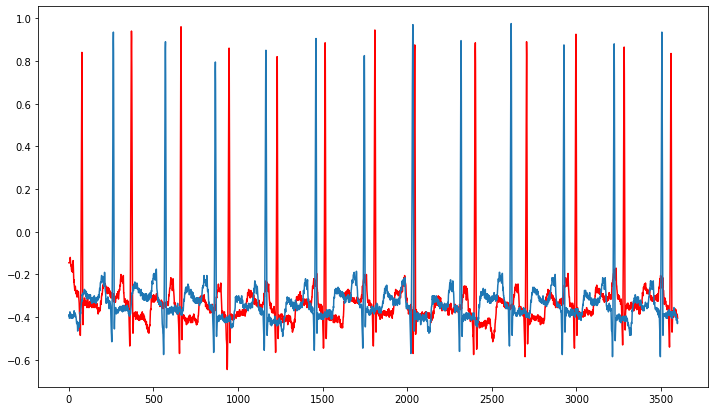

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(abnormal_sample, label='abnormal', color="red")
plt.plot(normal_sample, label='normal')
plt.show()

# Initial parameters

In [ ]:
normal_sample = np.array(normal_sample["Lead II"])
abnormal_sample = np.array(abnormal_sample["Lead II"])

In [ ]:
fs = len(normal_sample)/10 #Sampling rate, number of samples/sampling time
sample_size = 10 #seconds
path = "/content/drive/My Drive/Biosignal Analytics 2021/Data/"
class_list = ["normal/","abnormal/"]

Plotting a sample

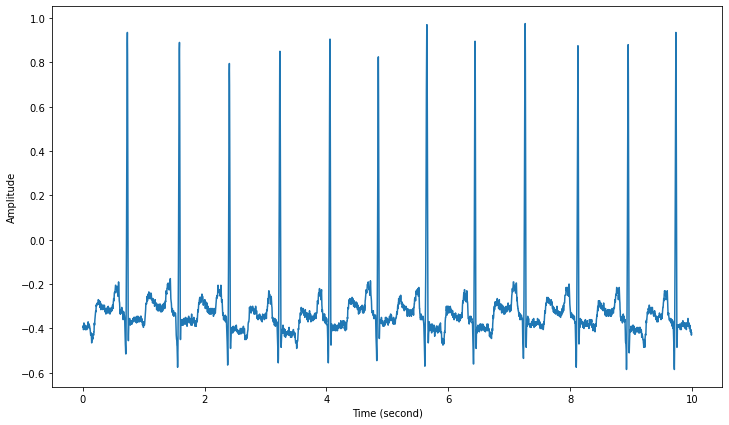

In [ ]:
mySample = pd.read_csv(path + class_list[0] + "sample_ID100_0.csv")
ts = np.arange(0,10,1/fs)
fig = plt.figure(figsize=(12,7))
plt.plot(ts, mySample)
plt.ylabel("Amplitude")
plt.xlabel("Time (second)")
plt.show()

# Set filenames and labels

In [ ]:
filenames = []
labels = []

for idx, cl in enumerate(class_list):
    files_list = glob.glob(path + cl + "/*.csv")
    filenames.extend(files_list)
    labels.extend([idx]*len(files_list))

In [ ]:
len(filenames) #7901 files with 3855 labeled as normal ECG and 4046 labeled as abnormal ECG

7901

# Filtering example

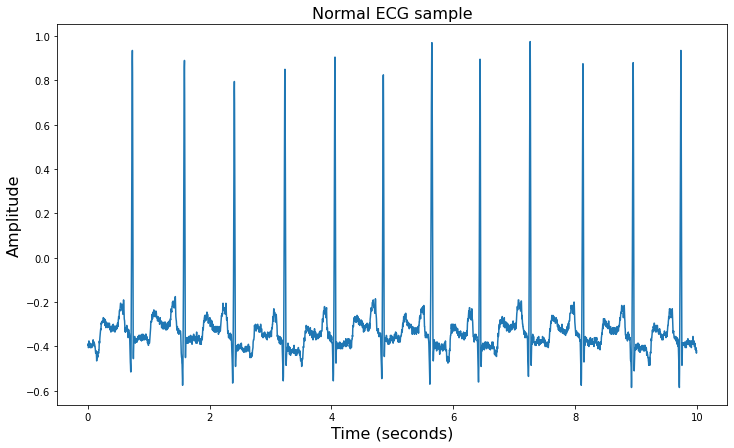

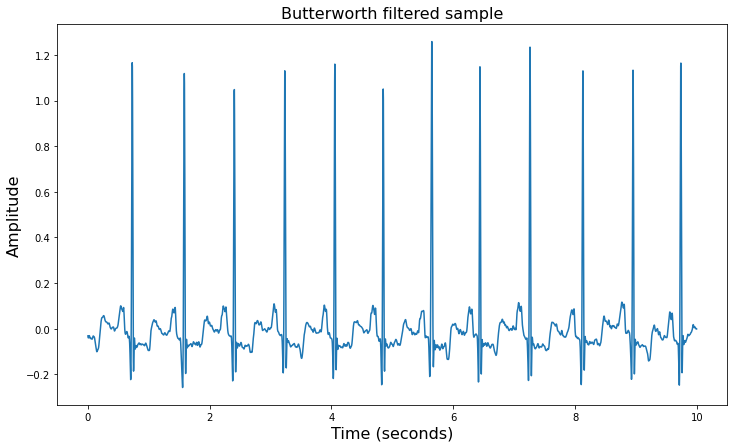

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(ts, mySample["Lead II"])
plt.title("Normal ECG sample",fontsize=16)
plt.xlabel("Time (seconds)",fontsize=16)
plt.ylabel("Amplitude",fontsize=16)
plt.show()

fc = np.array([0.5,40])
Wn = fc/(fs/2)
b, a = signal.butter(4, Wn, btype ='bandpass', analog=False)

filtered_sample = signal.filtfilt(b, a, mySample["Lead II"])
plt.figure(figsize=(12, 7))
plt.plot(ts, filtered_sample)
plt.title("Butterworth filtered sample",fontsize=16)
plt.xlabel("Time (seconds)",fontsize=16)
plt.ylabel("Amplitude",fontsize=16)
plt.show()

# R-peak detection example

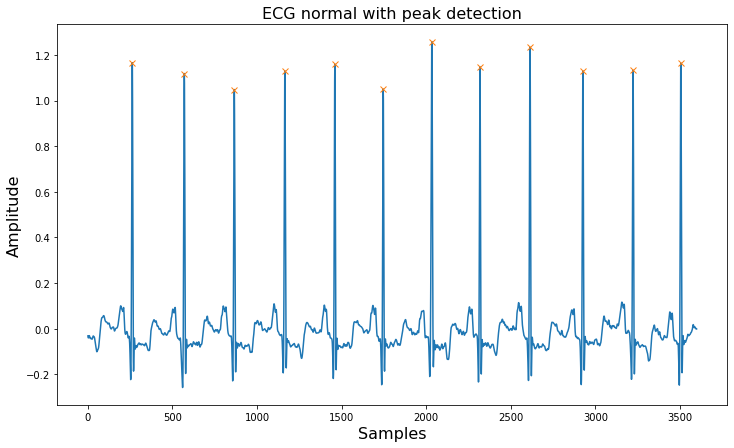

In [ ]:
ECG_peaks = ecg.hamilton_segmenter(filtered_sample, sampling_rate = fs)
plt.figure(figsize=(12, 7))
plt.plot(filtered_sample)
plt.plot(ECG_peaks[0], filtered_sample[ECG_peaks], "x")
plt.xlabel("Samples",fontsize=16)
plt.ylabel("Amplitude",fontsize=16)
plt.title("ECG normal with peak detection",fontsize=16)
plt.show()

#R-peak detection and feature extraction for all signals

In [ ]:
#Extracting waveform
def extract_waveform(arr, locs):
  w1,w2= int(0.4*fs), int(0.6*fs)
  waveforms = []
  for loc in locs:
    if (loc - w1 > 0) and (loc + w2 < len(arr)):
      l1, l2 = loc - w1, loc + w2
      waveforms.append(arr[l1:l2])
  return waveforms

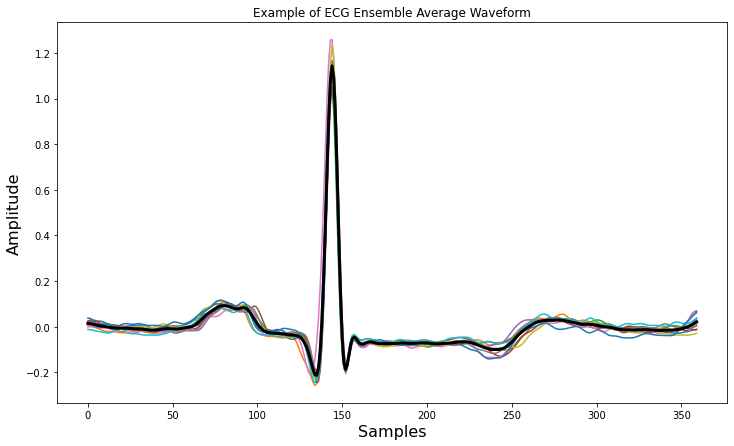

In [ ]:
#Example with ensemble average waveform
#First detecting R-peaks of a signal
R_peaks = ecg.hamilton_segmenter(signal = filtered_sample, sampling_rate =360)

#Splitting the signal into waveforms and calculating the average waveform
waveforms_ecg = extract_waveform(filtered_sample, R_peaks[0])
avg_waveform_ecg = np.mean(np.array(waveforms_ecg), axis=0)

plt.figure(figsize=(12, 7))
for waveform in waveforms_ecg:
  plt.plot(waveform)
plt.plot(avg_waveform_ecg, linewidth = 3, color = 'k')
plt.title("Example of ECG Ensemble Average Waveform")
plt.xlabel("Samples",fontsize=16)
plt.ylabel("Amplitude",fontsize=16)
plt.show()

In [ ]:
feature_matrix = pd.DataFrame(columns=["avg_waveform","r_loc","r_amplitude","rr_interval","t_loc","s_loc","st_duration","q_loc","qrs_duration","p_loc","pr_interval"])
for idx, fn in tqdm(enumerate(filenames)):
  
    #import a file
    df = pd.read_csv(fn)
    
    #filter the signals
    fc = np.array([0.5,40])
    Wn = fc/(fs/2)
    b, a = signal.butter(4, Wn, btype ='bandpass', analog=False)

    filtered = np.array(signal.filtfilt(b, a, df["Lead II"]))

    #Finding the R-peaks
    ECG_peaks = ecg.hamilton_segmenter(filtered, sampling_rate = fs)

    #R-R interval in seconds
    peak_times_s = ECG_peaks[0] / fs
    RR_intervals = np.diff(peak_times_s) 
    avg_RR_interval = np.average(RR_intervals)

    #Creating ensemble average waveform
    waveforms_ecg = extract_waveform(filtered, ECG_peaks[0])
    avg_waveform_ecg = np.mean(np.array(waveforms_ecg), axis=0)

    #R-peak location
    r_loc = np.argmax(avg_waveform_ecg)
    
    #R-peak amplitude
    r_amplitude = avg_waveform_ecg[r_loc]

    #T-wave peak location
    start = int(0.6*fs)
    end = int(0.8*fs)
    t_loc = start + np.argmax(avg_waveform_ecg[start:end])

    #Q-wave peak location
    q_loc = 128 + np.argmin(avg_waveform_ecg[128:144])

    #S-wave peak location
    s_loc =  144 + np.argmin(avg_waveform_ecg[144:160])
    
    #ST-duration in seconds
    st_duration = (t_loc - s_loc) / fs

    #QRS-duration in seconds
    qrs_duration = (s_loc - q_loc) / fs

    #P-wave peak location
    p_loc = 50 + np.argmax(avg_waveform_ecg[50:120])
   
    #PR-interval in seconds 
    pr_interval = (r_loc - p_loc) / fs

    feature_matrix.loc[idx] = avg_waveform_ecg, r_loc, r_amplitude, avg_RR_interval, t_loc, s_loc, st_duration, q_loc, qrs_duration, p_loc, pr_interval

7901it [38:48,  3.39it/s]


In [ ]:
feature_matrix

,avg_waveform,r_loc,r_amplitude,rr_interval,t_loc,s_loc,st_duration,q_loc,qrs_duration,p_loc,pr_interval
0,"[0.17463528858611516, 0.16516222104896186, 0.1...",144,1.219086,0.648016,223,152,0.197222,134,0.050000,82,0.172222
1,"[0.030588760699426128, 0.02043119151776531, 0....",144,1.624012,0.662103,225,152,0.202778,128,0.066667,95,0.136111
2,"[-0.020459132555192296, -0.019088940995409132,...",144,1.169010,0.696154,269,159,0.305556,129,0.083333,107,0.102778
3,"[-0.05296116460469864, -0.0626323527441557, -0...",144,1.588215,0.687302,226,152,0.205556,128,0.066667,96,0.133333
4,"[0.17698876795897295, 0.16995512180730368, 0.1...",144,1.190822,0.636706,224,152,0.200000,135,0.047222,83,0.169444
...,...,...,...,...,...,...,...,...,...,...,...
7896,"[0.07025850551552619, 0.05478471523957292, 0.0...",144,1.527266,0.711752,243,159,0.233333,130,0.080556,93,0.141667
7897,"[0.052514507448598764, 0.04078530098333773, 0....",144,1.531309,0.722650,245,159,0.238889,130,0.080556,92,0.144444
7898,"[0.07832751843705604, 0.06513153700856023, 0.0...",144,1.462301,0.728205,244,159,0.236111,130,0.080556,90,0.150000
7899,"[-0.004279316587633849, -0.012459217162158564,...",144,1.509039,0.727991,246,159,0.241667,129,0.083333,91,0.147222


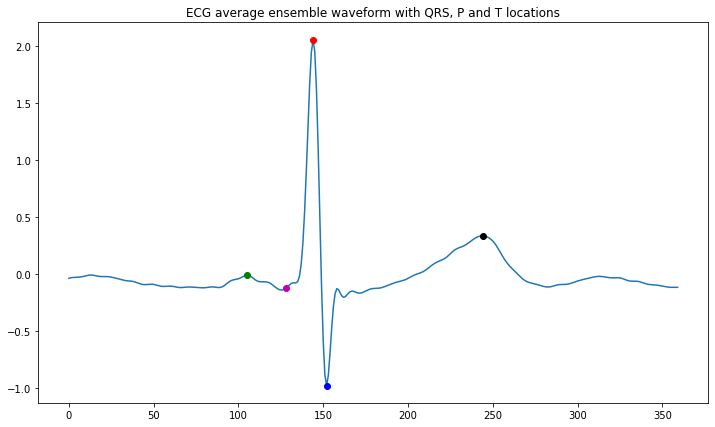

0
/content/drive/My Drive/Biosignal Analytics 2021/Data/normal/sample_ID220_110.csv


In [ ]:
#change this to plot other signals
filenum = 250

plt.figure(figsize=(12, 7))
plt.plot(feature_matrix["avg_waveform"][filenum])
plt.plot(feature_matrix["r_loc"][filenum], feature_matrix["avg_waveform"][filenum][feature_matrix["r_loc"][filenum]], 'ro')
plt.plot(feature_matrix["t_loc"][filenum], feature_matrix["avg_waveform"][filenum][feature_matrix["t_loc"][filenum]], 'ko')
plt.plot(feature_matrix["s_loc"][filenum], feature_matrix["avg_waveform"][filenum][feature_matrix["s_loc"][filenum]], 'bo')
plt.plot(feature_matrix["p_loc"][filenum], feature_matrix["avg_waveform"][filenum][feature_matrix["p_loc"][filenum]], 'go')
plt.plot(feature_matrix["q_loc"][filenum], feature_matrix["avg_waveform"][filenum][feature_matrix["q_loc"][filenum]], 'mo')
plt.title("ECG average ensemble waveform with QRS, P and T locations")
plt.show()
print(labels[filenum])
print(filenames[filenum])

Moreover, Training Data extracts 5 features in the temporal domain [36] for each ECG cycle. The
features include QRS complex duration, T wave duration, RR interval, PR interval and ST segment. -- HiCH: Hierarchical Fog-Assisted Computing Architecture
for Healthcare IoT

# kNN Classifier

In [ ]:
#QRS-amplitude, QRS-duration, RR-interval, PR-interval and ST-duration as features
X = feature_matrix[["r_amplitude","rr_interval","st_duration","qrs_duration","pr_interval"]].copy()
#Labels: 0 for normal, 1 for abnormal
y = np.array(labels)

In [ ]:
#Splitting into 70% training set/30% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#Normalizing data
X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)
X_train_norm = (X_train - X_train_mean)/X_train_std
X_test_norm = (X_test - X_train_mean)/X_train_std

In [ ]:
clf = KNeighborsClassifier(n_neighbors=3)

clf.fit(X_train_norm, y_train)

y_pred = clf.predict(X_test_norm)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))
print("Precision: {:.3f}".format(metrics.precision_score(y_test, y_pred)))
#print(metrics.precision_score(y_test, y_pred, average=None))
print("Recall: {:.3f}".format(metrics.recall_score(y_test, y_pred)))
#print(metrics.recall_score(y_test, y_pred, average=None))
print("F1 score: {:.3f}".format(metrics.f1_score(y_test, y_pred)))
#print(metrics.f1_score(y_test, y_pred, average=None))
print("Accuracy: {:.3f}".format(metrics.accuracy_score(y_test,y_pred)))

Confusion matrix:
[[1062   82]
 [ 134 1093]]
Precision: 0.930
Recall: 0.891
F1 score: 0.910
Accuracy: 0.909


# SVM Classifier

In [ ]:
from sklearn.svm import SVC

clf = SVC()

clf.fit(X_train_norm, y_train)

y_pred = clf.predict(X_test_norm)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))
print("Precision: {:.3f}".format(metrics.precision_score(y_test, y_pred)))
#print(metrics.precision_score(y_test, y_pred, average=None))
print("Recall: {:.3f}".format(metrics.recall_score(y_test, y_pred)))
#print(metrics.recall_score(y_test, y_pred, average=None))
print("F1 score: {:.3f}".format(metrics.f1_score(y_test, y_pred)))
#print(metrics.f1_score(y_test, y_pred, average=None))
print("Accuracy: {:.3f}".format(metrics.accuracy_score(y_test,y_pred)))

Confusion matrix:
[[1003  141]
 [ 271  956]]
Precision: 0.871
Recall: 0.779
F1 score: 0.823
Accuracy: 0.826


# Principal Component Analysis

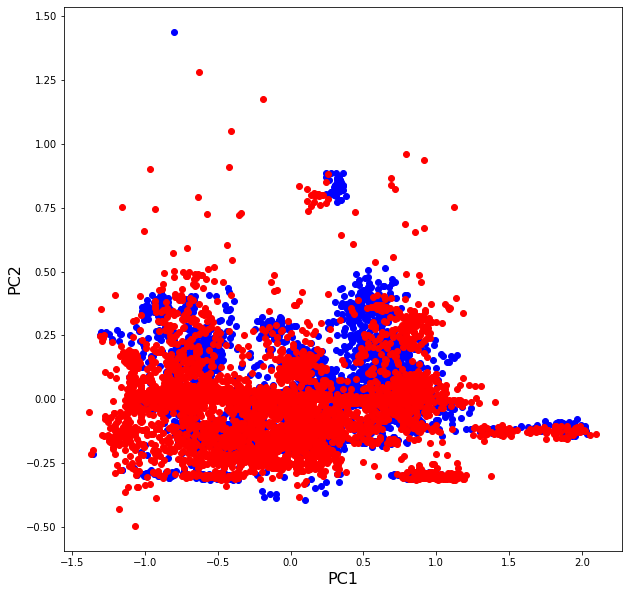

In [ ]:
#Computing PCA with two components
pca = PCA(n_components=2)
pca_out = pca.fit_transform(X)

cdict = {0:'blue',1:'red'}

#Plotting with first component as x-axis and second component as y-axis
plt.figure(figsize=(10,10))
for i in range(len(X)):
  plt.scatter(pca_out[:,0][i],pca_out[:,1][i], c=cdict[y[i]])


plt.xlabel('PC1',fontsize=16)
plt.ylabel('PC2',fontsize=16)

plt.show()

In [ ]:
###########################################################################################################################################################################################